## Import library

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torchvision import datasets, transforms
import help
from torch import nn, optim
import torch.nn.functional as F
import fc_model


import matplotlib.pyplot as plt

### Load the dataset

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

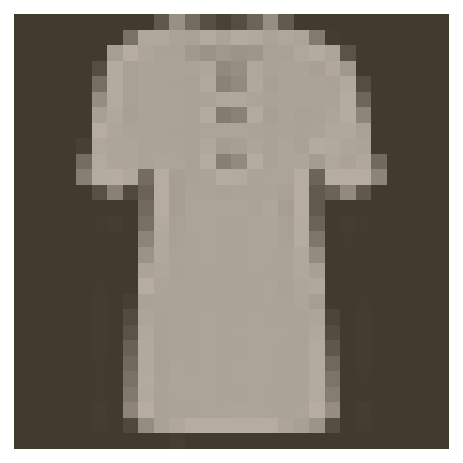

In [7]:
image, label = next(iter(trainloader))
help.imshow(image[0,:]);

## Build the network

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make su re input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Train the network

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [13]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.515423892991248
Training loss: 0.39402643533975584
Training loss: 0.3564056646086768
Training loss: 0.3346765467972517
Training loss: 0.31838325310204585


## Test the model 

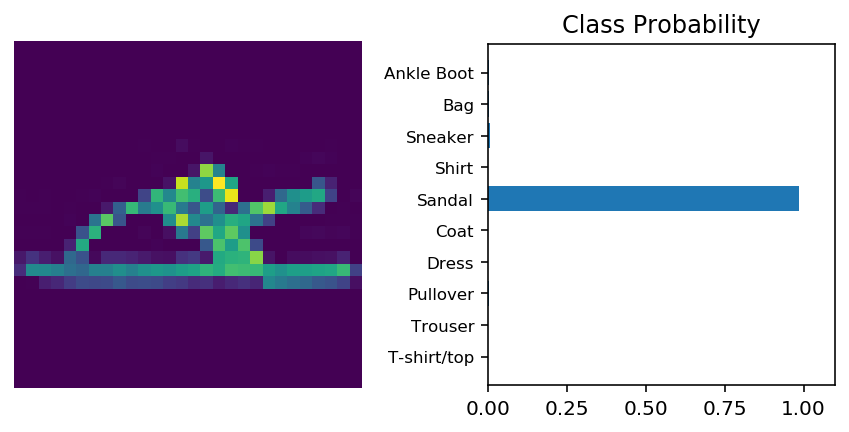

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
help.view_classify(img, ps, version='Fashion')

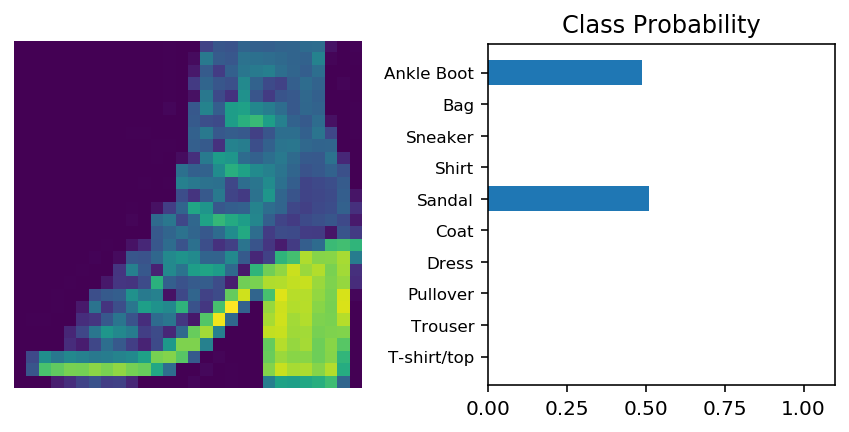

In [16]:
img_2 = images[3]
ps_2 = torch.exp(model(img_2))

# Plot the image and probabilities
help.view_classify(img_2, ps_2, version='Fashion')

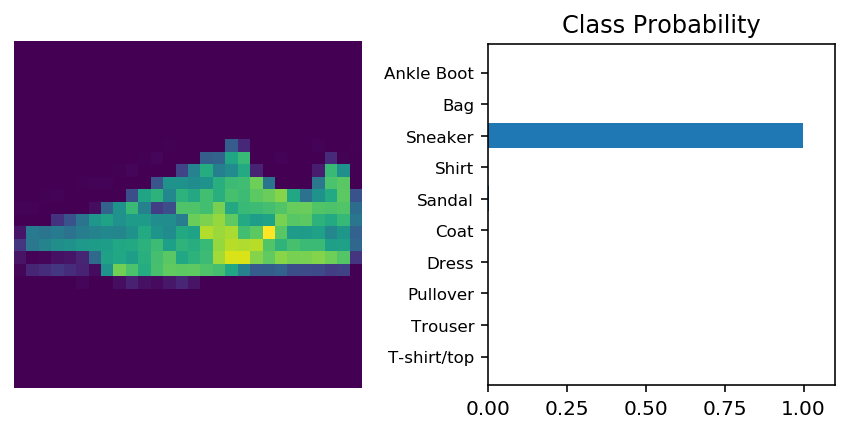

In [17]:
img_3 = images[10]
ps_3 = torch.exp(model(img_3))

# Plot the image and probabilities
help.view_classify(img_3, ps_3, version='Fashion')

### Validation

In [18]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[5]])


In [23]:
equals = top_class == labels

In [24]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 6.25%


### TRAINING OUR MODEL TO IMPLEMENT THE VALIDATION LOOP

In [27]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.438..  Test Accuracy: 0.840
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.425..  Test Accuracy: 0.847
Epoch: 3/30..  Training Loss: 0.356..  Test Loss: 0.389..  Test Accuracy: 0.862
Epoch: 4/30..  Training Loss: 0.331..  Test Loss: 0.390..  Test Accuracy: 0.858
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.366..  Test Accuracy: 0.871
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.347..  Test Accuracy: 0.878
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.377..  Test Accuracy: 0.869
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.370..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.378..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.371..  Test Accuracy: 0.875
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.378..  Test Accuracy: 0.879
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.413..  Test Accuracy: 0.861
Epoch: 13/30..  Training Loss: 0.247.

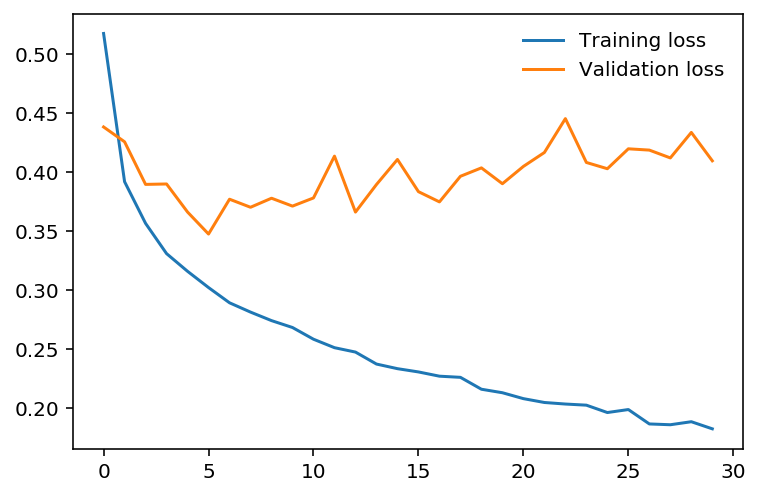

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [29]:
## We can make an inference that our model is overfitting by seeing validation loss curve far from the training loss curve

### Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [30]:
class ClassifierWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [31]:
model_with_dropout = ClassifierWithDropout()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model_with_dropout(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model_with_dropout.eval()
            for images, labels in testloader:
                log_ps = model_with_dropout(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.612..  Test Loss: 0.502..  Test Accuracy: 0.816
Epoch: 2/30..  Training Loss: 0.400..  Test Loss: 0.405..  Test Accuracy: 0.856
Epoch: 3/30..  Training Loss: 0.361..  Test Loss: 0.408..  Test Accuracy: 0.857
Epoch: 4/30..  Training Loss: 0.334..  Test Loss: 0.396..  Test Accuracy: 0.864
Epoch: 5/30..  Training Loss: 0.322..  Test Loss: 0.378..  Test Accuracy: 0.866
Epoch: 6/30..  Training Loss: 0.309..  Test Loss: 0.380..  Test Accuracy: 0.866
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.365..  Test Accuracy: 0.870
Epoch: 8/30..  Training Loss: 0.287..  Test Loss: 0.380..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.354..  Test Accuracy: 0.876
Epoch: 10/30..  Training Loss: 0.272..  Test Loss: 0.359..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.383..  Test Accuracy: 0.870
Epoch: 12/30..  Training Loss: 0.253..  Test Loss: 0.364..  Test Accuracy: 0.878
Epoch: 13/30..  Training Loss: 0.249.

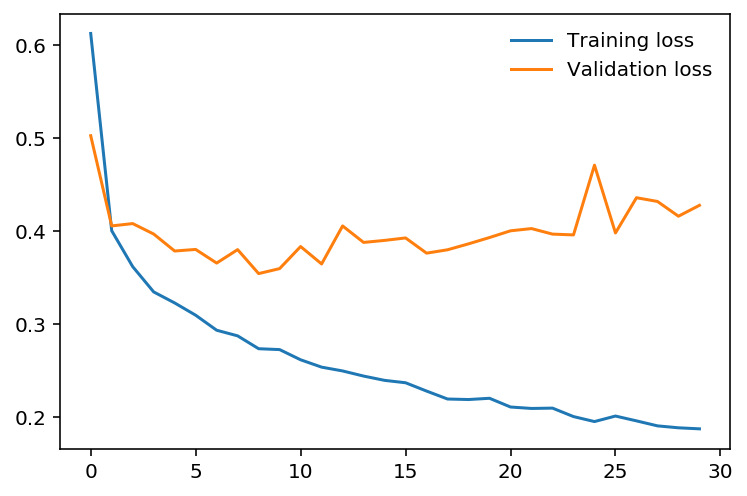

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

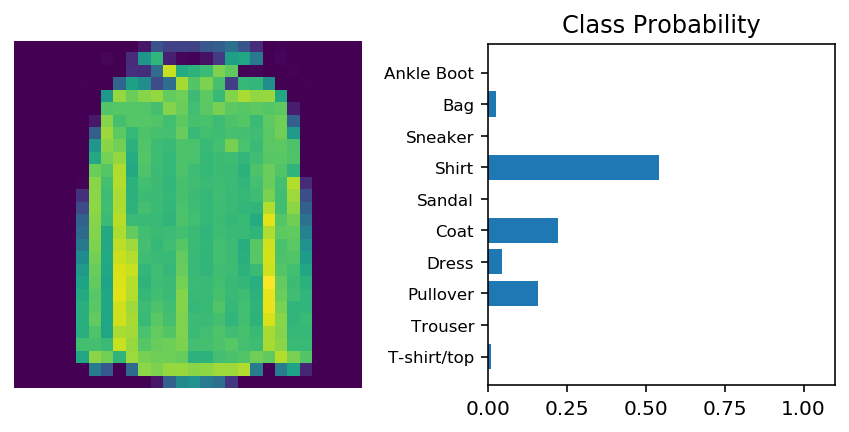

In [35]:
model_with_dropout.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model_with_dropout.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
help.view_classify(img.view(1, 28, 28), ps, version='Fashion')

##  EXTRA   --Saving and Loading the Model 

In [8]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.666..  Test Loss: 0.976..  Test Accuracy: 0.618
Epoch: 1/2..  Training Loss: 1.062..  Test Loss: 0.739..  Test Accuracy: 0.725
Epoch: 1/2..  Training Loss: 0.863..  Test Loss: 0.687..  Test Accuracy: 0.731
Epoch: 1/2..  Training Loss: 0.792..  Test Loss: 0.686..  Test Accuracy: 0.735
Epoch: 1/2..  Training Loss: 0.794..  Test Loss: 0.638..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.742..  Test Loss: 0.602..  Test Accuracy: 0.778
Epoch: 1/2..  Training Loss: 0.715..  Test Loss: 0.579..  Test Accuracy: 0.783
Epoch: 1/2..  Training Loss: 0.670..  Test Loss: 0.560..  Test Accuracy: 0.785
Epoch: 1/2..  Training Loss: 0.680..  Test Loss: 0.575..  Test Accuracy: 0.784
Epoch: 1/2..  Training Loss: 0.632..  Test Loss: 0.545..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.665..  Test Loss: 0.525..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.648..  Test Loss: 0.541..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.578..  Test Loss: 0.5

In [10]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [13]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'model_checkpoint.pth')

In [14]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [15]:
model = load_checkpoint('model_checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
